<a href="https://colab.research.google.com/github/imenebak/Sentiment-Analysis/blob/main/SentimentAnalysisKaggelTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine.

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
from google.colab import files
files.upload()  #this will prompt you to upload the kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"imene1","key":"530376e9251817b9ad7cfc8cc5cd9a5a"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
! kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 66% 17.0M/25.7M [00:00<00:00, 20.2MB/s]
100% 25.7M/25.7M [00:00<00:00, 27.9MB/s]


In [ ]:
!unzip imdb-dataset-of-50k-movie-reviews

Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [ ]:
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv")

movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [ ]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Summary of the dataset
movie_reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [ ]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

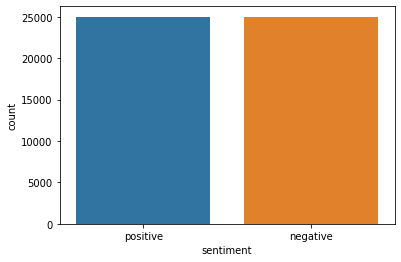

In [ ]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
movie_reviews.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64




---



*   As the sentences have html line breaks in them, they would be replaced with "." prior to next steps of preprocessing, else the tags would lose meaning and dilute the sentences.

*   Inspecting the dataset reveled that there are ( ½, ¾, ,ª,³,º) characters which are not numbers and hence have been cleaned explictly.


*   TweetTokenizer - seems to be smartly seperating numbers into different token i.e. "entries.3/10" is sepeared into two tokens "entries" and "310" so that we can remove 310 in next iterations, also TweetTokenizer is idenityfing words like "cannot" and "gonna" as one token. TreebankWordTokenizer and word tokenizer are identifying "entries310" as one token and "cannot" as two tokens i.e. "can" and "not" and hence TweetTokenizer is chosen.
*   As the corupus mostly contain english words, I have chosen to remove english stop words exlcuding "n't","nt", "not", "no" as they might contribute to sentiment.
numbers have also been removed
There are a lot of words which are seperated by punctuation marks and not by space for example - crazy-Chinese-musical-in-Paris-with-Barbet-Schroeder but.oh.dear.god.it.sounds.like.they're.all.reading.from.scripts. Hence for words with size greater than 20 punctuation marks and underscore have been replaced by space and for the rest punctuation marks have been removed.


*   Hyperlinks have also been removed using regex patterns
Using Lemmatisation over stemming as words like "flies" will be handled better using Lemmatisation
Underscores are handled differently than punctuation marks as there are some curse words censored by underscre example - f__ed, if we remove underscore completely then the meaning of the word changes entirely, hence tokens that **have at the beginning / end** have been handled using st.stip("_") and underscore in between tokens with size less than 20 have been left at they are.

*  A lot of user exclaimed words were also found in different forms (example - yeeshhhhhhhhhhhhhhhhh) and hence the most frequent ones have been identified and replaced by the respective words using regex patterns.
* There are also multiple words which are not seperated by space or punctuation mark,(Example - heyijustleftmycoatbehind) these are hardcoded into a dict and then replaced